# Classification with MLP

Program ini dijalankan menggunakan [Google Colab](https://colab.research.google.com)

Input yang digunakan pada program ini merupakan file dengan deskripsi 18 kolom fitur Image Quality Assessment dan 1 kolom kelas dengan ekstensi **.csv**

fitur tercantum pada [qualitymeasure](https://https://www.idiap.ch/software/bob/docs/bob/bob.ip.qualitymeasure/master/index.html) dari Bob Toolbox Machine Learning

pada program ini menggunakan [earlystopping from pytorchtools](https://github.com/Bjarten/early-stopping-pytorch) untuk menghentikan iterasi saat nilai validation loss naik

Versi library yang digunakan saat pengerjaan

> numpy : versi 1.19.5

> pandas : 1.1.5

> seaborn versi 0.11.1

> pyTorch versi 1.9.0

> scikit-learn versi 0.22.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
#from pytorchtools import EarlyStopping

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import files

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_class_distribution(obj):
  count_dict = {"real" : 0,
                "attack" : 0}
  for i in obj:
    if i == 0 :
      count_dict["real"] += 1
    elif i == 1:
      count_dict["attack"] += 1
    else:
      print("Check classes.")
  return count_dict

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [1]:
#18-Feature
label18 = ['mse00', 'psnr01', 'ad02', 'sc03', 'nk04', 'md05',
         'lmse06', 'nae07', 'snrv08', 'ramdv09', 'mas10', 'mams11',
         'sme12', 'gme16', 'gpe17', 'ssim18', 'vif19', 'hlfi25','class']

In [ ]:
df = pd.read_csv("/content/drive/dataset.csv")

In [ ]:
df_train = df[label18].loc[(df.session != 3)]
df_test = df[label18].loc[(df.session == 3)]
df_for_error = df.loc[(df.session == 3)]

In [ ]:
train =  df_train.copy()
test = df_test.copy()

In [ ]:
encode_map = {"real":0,
              "paper":1,
              "replay":1}

train['class'].replace(encode_map, inplace=True)
test['class'].replace(encode_map, inplace=True)

In [ ]:
train_value, train_class = train.iloc[:,:18], train.iloc[:,-1]
X_train, X_val, y_train, y_val = train_test_split(train_value, np.array(train_class),
                                                  test_size=0.1, stratify=train_class,
                                                  random_state=101)
X_test, y_test = test.iloc[:,:18], test.iloc[:,-1]

In [ ]:
y_index = np.array(y_test.index)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

In [ ]:
scaler.mean_

In [ ]:
scaler.scale_

In [ ]:
bestfeatures = SelectKBest(score_func=f_classif, k= 18)
best = bestfeatures.fit(X_train, y_train)
X_train_fs = bestfeatures.transform(X_train_sc)
X_test_fs = bestfeatures.transform(X_test_sc)
X_val_fs = bestfeatures.transform(X_val_sc)

In [ ]:
#menampilkan skor dari f_classif (Anova-F)
dfscores = pd.DataFrame(best.scores_)
dfcolumns = pd.DataFrame(label18)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
print(featureScores.nlargest(18,'Score'))

In [ ]:
#membuat loader dataset custom untuk masukan torch

class ClassifierDataset(Dataset):

  def __init__(self, X_data, y_data):
    self.X_data = X_data
    self.y_data = y_data
  
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]

  def __len__ (self):
    return len(self.X_data)

In [ ]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train_fs).float(), torch.from_numpy(y_train))
val_dataset = ClassifierDataset(torch.from_numpy(X_val_fs).float(), torch.from_numpy(y_val))
test_dataset = ClassifierDataset(torch.from_numpy(X_test_fs).float(), torch.from_numpy(y_test))

In [ ]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.long)
print(class_weights)

class_weights_all = class_weights[target_list]

weighted_sampler = WeightedRandomSampler(weights=class_weights_all,
                                         num_samples=len(class_weights_all),
                                         replacement=True)

In [ ]:
EPOCHS = 300
BATCH_SIZE = 200
LEARNING_RATE = 0.0007

NUM_FEATURES = len(X_train_fs[0])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self, num_features):
        super(binaryClassification, self).__init__()
        self.layer_1 = nn.Linear(num_features, 60) 
        self.layer_2 = nn.Linear(60, 45)
        self.layer_3 = nn.Linear(45, 32)
        self.layer_out = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))

        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = binaryClassification(num_features=NUM_FEATURES)
model.to(device)

print(device)
print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
accuracy_stats = {"train": [],
                  "val": []}

loss_stats = {"train": [],
              "val": []}

## Training

In [ ]:
print("Begin training.")

early_stopping = EarlyStopping(patience = 7, verbose=True)
for e in tqdm(range(1, EPOCHS+1)):

    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()

    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1).type_as(y_train_pred))
        train_acc = binary_acc(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = model(X_val_batch)
                      
          val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1).type_as(y_val_pred))
          val_acc = binary_acc(y_val_pred, y_val_batch.unsqueeze(1))
          
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()


        
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              

        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

    early_stopping(val_epoch_loss/len(val_loader), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break  

Text(0.5, 1.0, 'Train-Validation Loss/Epoch')

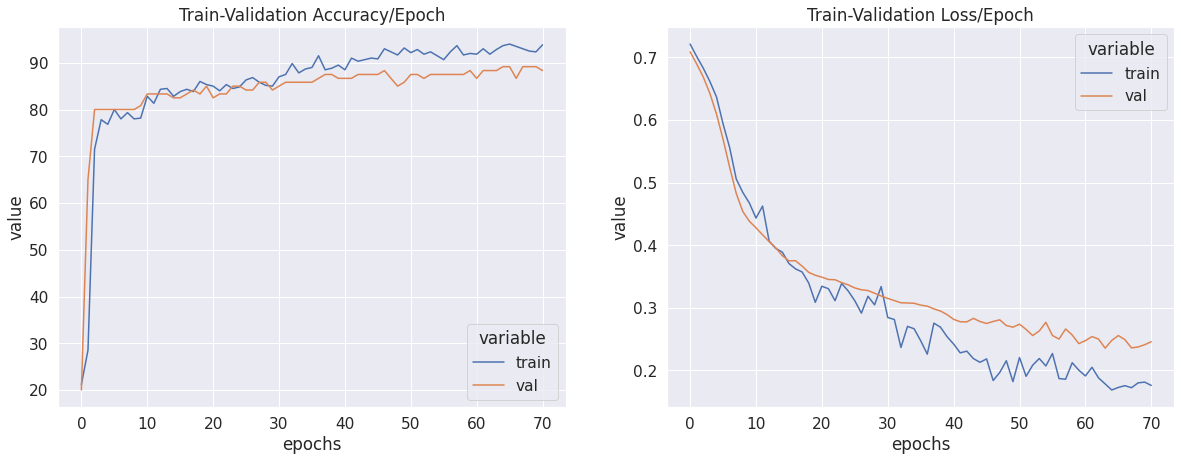

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df,
             x = "epochs", y="value", hue = 'variable',
             ax=axes[0]).set_title('Train-Validation Accuracy/Epoch')

sns.lineplot(data=train_val_loss_df,
             x = "epochs", y="value", hue = 'variable',
             ax=axes[1]).set_title('Train-Validation Loss/Epoch')

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch[0].to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
#Real vs All -- 18 Fitur
print(classification_report(y_test, y_pred_list, target_names=['real', 'attack']))
np.array(confusion_matrix(y_test, y_pred_list))

              precision    recall  f1-score   support

        real       0.63      0.60      0.62       120
      attack       0.90      0.91      0.91       480

    accuracy                           0.85       600
   macro avg       0.77      0.76      0.76       600
weighted avg       0.85      0.85      0.85       600



array([[ 72,  48],
       [ 42, 438]])

Text(0.5, 1.0, 'Multilayer perceptron 10 Fitur')

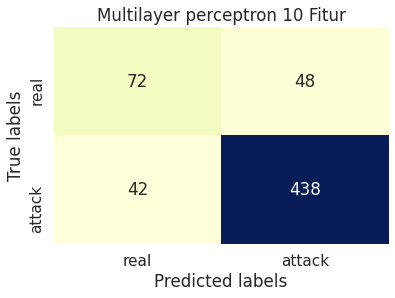

In [ ]:
ax= plt.subplot()
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, y_pred_list),
            annot=True, fmt="d", cbar =False, cmap="YlGnBu")

tl = 'Multilayer perceptron 10 Fitur'
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

ax.xaxis.set_ticklabels(['real', 'attack'])
ax.yaxis.set_ticklabels(['real', 'attack'])
plt.title(tl)

plt.savefig(f"{tl}.png")
files.download(f"{tl}.png")

## Error Analysis

In [ ]:
diff_list, diff_index = [], []
for i in range(len(y_test)):
  if y_test[i] == y_pred_list[i]: 
    diff_list.append(True)
  else:
    diff_index.append(i)
    diff_list.append(False)

In [ ]:
df_err = df_test.iloc[diff_index, :]

In [ ]:
df_error = df.iloc[df_err.index,:]

In [ ]:
df_error.to_csv("error_realvsall_bysession.csv")